In [35]:
!pip install pynvml numba
!pip install evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 1.9 MB/s eta 0:00:00a 0:00:01


In [2]:
import random
from collections import Counter
from tqdm import tqdm

import torch
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [3]:
import torch 
import torch.nn as nn
from transformers import EsmTokenizer, EsmForSequenceClassification

In [4]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"

In [5]:
device

'cuda:0'

In [6]:
import torch

torch.cuda.is_available(), torch.cuda.device_count(), torch.cuda.current_device(), torch.cuda.device(0), torch.cuda.get_device_name(0)

(True, 1, 0, <torch.cuda.device at 0x7f531ca31fd0>, 'Quadro P6000')

In [9]:
from pynvml import *


def print_gpu_utilization():
    nvmlInit()
    handle = nvmlDeviceGetHandleByIndex(0)
    info = nvmlDeviceGetMemoryInfo(handle)
    print(f"GPU memory occupied: {info.used//1024**2} MB.")


def print_summary(result):
    print(f"Time: {result.metrics['train_runtime']:.2f}")
    print(f"Samples/second: {result.metrics['train_samples_per_second']:.2f}")
    print_gpu_utilization()

from numba import cuda 
device = cuda.get_current_device()
device.reset()


In [11]:
print_gpu_utilization()

GPU memory occupied: 136 MB.


In [12]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

tokenizer = AutoTokenizer.from_pretrained("jaykmr/ESMCrystal_t6_8M_v1")
model = AutoModelForSequenceClassification.from_pretrained("jaykmr/ESMCrystal_t6_8M_v1").to(device)

tokenizer_config.json:   0%|          | 0.00/40.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/93.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/833 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/31.4M [00:00<?, ?B/s]

Some weights of EsmForSequenceClassification were not initialized from the model checkpoint at jaykmr/ESMCrystal_t6_8M_v1 and are newly initialized: ['esm.contact_head.regression.weight', 'esm.contact_head.regression.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [78]:
import csv
testcsvfilepath = "Datasets/test.csv"

X_test = []
y_test = []

with open(testcsvfilepath) as testcsvfile:
    csvreader = csv.reader(testcsvfile)
    for row in csvreader:
        #print(row)
        if '1' not in row and '0' not in row:
            X_test.append(row[0])
        elif '1' in row:
            y_test.append(1)
        elif '0' in row:
            y_test.append(0)
        else:
            pass

In [79]:
X_test[0], len(X_test[0])

('MYRVFVFDLDGTLLNDNLEISEKDRRNIEKLSRKCYVVFASGRMLVSTLNVEKKYFKRTFPTIAYNGAIVYLPEEGVILNEKIPPEVAKDIIEYIKPLNVHWQAYIDDVLYSEKDNEEIKSYARHSNVDYRVEPNLSELVSKMGTTKLLLIDTPERLDELKEILSERFKDVVKVFKSFPTYLEIVPKNVDKGKALRFLRERMNWKKEEIVVFGDNENDLFMFEEAGLRVAMENAIEKVKEASDIVTLTNNDSGVSYVLERISTDCLDE',
 268)

In [15]:
y_test[0]

1

In [16]:
len(X_test), len(y_test)

(1898, 1898)

In [17]:
from datasets import Dataset
from torch.utils.data import DataLoader

In [18]:
test_ds = Dataset.from_dict({ 
                        "input_ids": tokenizer(X_test, padding=True,  # Pad to max_length
                                              truncation=True,
                              return_tensors='pt').to(device)["input_ids"],
                        "attention_mask": tokenizer(X_test, padding=True,  # Pad to max_length
                                              truncation=True,
                              return_tensors='pt').to(device)["attention_mask"],
                        "label": y_test}, split="test").with_format("torch")

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


In [19]:
test_ds

Dataset({
    features: ['input_ids', 'attention_mask', 'label'],
    num_rows: 1898
})

In [26]:
test_loader = DataLoader(test_ds, batch_size=32)

In [29]:
test_loader

In [30]:
from transformers import pipeline
pipeline = pipeline(task="text-classification", model=model, tokenizer=tokenizer, device=device)

In [32]:
predictions = pipeline(X_test)

In [33]:
predictions

[{'label': 'LABEL_1', 'score': 0.9920824766159058},
 {'label': 'LABEL_0', 'score': 0.6344404816627502},
 {'label': 'LABEL_1', 'score': 0.9963781237602234},
 {'label': 'LABEL_1', 'score': 0.8957202434539795},
 {'label': 'LABEL_0', 'score': 0.9899581074714661},
 {'label': 'LABEL_0', 'score': 0.992432713508606},
 {'label': 'LABEL_1', 'score': 0.9936670660972595},
 {'label': 'LABEL_0', 'score': 0.9957142472267151},
 {'label': 'LABEL_1', 'score': 0.7678724527359009},
 {'label': 'LABEL_0', 'score': 0.9950073957443237},
 {'label': 'LABEL_0', 'score': 0.9934017062187195},
 {'label': 'LABEL_0', 'score': 0.9901747703552246},
 {'label': 'LABEL_0', 'score': 0.9942784309387207},
 {'label': 'LABEL_1', 'score': 0.9712179899215698},
 {'label': 'LABEL_0', 'score': 0.9931582808494568},
 {'label': 'LABEL_0', 'score': 0.9989894032478333},
 {'label': 'LABEL_0', 'score': 0.9962522387504578},
 {'label': 'LABEL_0', 'score': 0.8317552208900452},
 {'label': 'LABEL_0', 'score': 0.980193555355072},
 {'label': 'LA

In [36]:
import numpy as np
import evaluate
from sklearn.metrics import accuracy_score

In [42]:
preds = [int(x["label"].split("_")[1]) for x in predictions]

In [63]:
predictions_proba = np.array([x["score"] if int(x["label"].split("_")[1]) == 1 else (1.0 - x["score"]) for x in predictions])

In [64]:
predictions_probs = np.array([np.array([x["score"], (1.0 - x["score"])]) if int(x["label"].split("_")[1]) == 0 else np.array([(1.0 - x["score"]), x["score"]]) for x in predictions])

In [65]:
preds[0], y_test[0], predictions_proba[0], predictions_probs[0]

(1, 1, 0.9920824766159058, array([0.00791752, 0.99208248]))

In [66]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
target_names = ['non-crystallizable', 'crystallizable']

print(classification_report(y_test, preds, target_names=target_names))
print(confusion_matrix(y_test, preds))
print(roc_auc_score(y_test, predictions_proba))

                    precision    recall  f1-score   support

non-crystallizable       0.73      0.97      0.83      1000
    crystallizable       0.94      0.60      0.73       898

          accuracy                           0.79      1898
         macro avg       0.83      0.78      0.78      1898
      weighted avg       0.83      0.79      0.78      1898

[[966  34]
 [362 536]]
0.9467594654788418


In [67]:
print(roc_auc_score(y_test, predictions_proba))

0.9467594654788418


In [59]:
from sklearn.metrics import roc_curve, auc
n_classes = 2
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test, predictions_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test, predictions_proba)
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

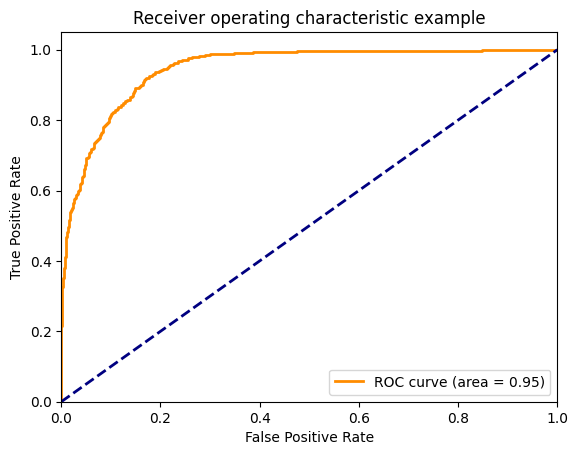

In [60]:
import matplotlib.pyplot as plt
plt.figure()
lw = 2
plt.plot(
    fpr[1],
    tpr[1],
    color="darkorange",
    lw=lw,
    label="ROC curve (area = %0.2f)" % roc_auc[1],
)
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic example")
plt.legend(loc="lower right")
plt.show()

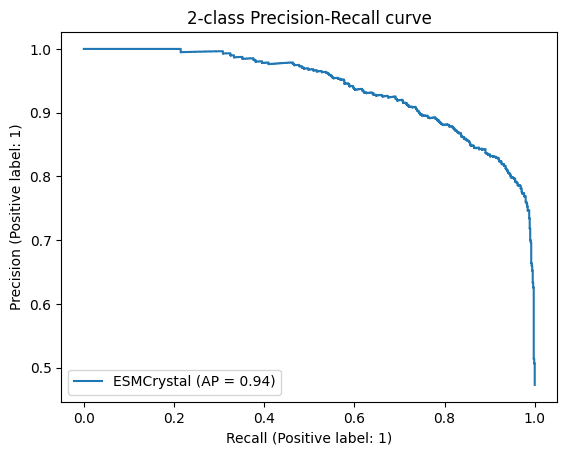

In [74]:
from sklearn.metrics import PrecisionRecallDisplay

import matplotlib.pyplot as plt
fig, ax = plt.subplots()
display = PrecisionRecallDisplay.from_predictions(y_test, predictions_proba, name="ESMCrystal", ax=ax)
_ = display.ax_.set_title("2-class Precision-Recall curve")
plt.show()


In [88]:
import csv

testdatacsvfilepath = "Datasets/BCrystal_Balanced_Test_set/test.fasta"
testcsvfilepath = "Datasets/BCrystal_Balanced_Test_set/y_test.csv"

X_test_B = []
y_test_B = []

with open(testdatacsvfilepath) as testcsvfile:
    csvreader = csv.reader(testcsvfile)
    for row in csvreader:
        #print(row)
        if '>' not in row[0]:
            X_test_B.append(row[0])
        else:
            pass
        
with open(testcsvfilepath) as testcsvfile:
    csvreader = csv.reader(testcsvfile)
    for row in csvreader:
        #print(row)
        if '1' in row:
            y_test_B.append(1)
        elif '0' in row:
            y_test_B.append(0)
        else:
            pass

In [89]:
X_test_B[0], len(X_test_B[0]), len(X_test_B), y_test_B[0], len(y_test_B)

('MRVLFIGDVFGQPGRRVLQNHLPTIRPQFDFVIVNMENSAGGFGMHRDAARGALEAGAGCLTLGNHAWHHKDIYPMLSEDTYPIVRPLNYADPGTPGVGWRTFDVNGEKLTVVNLLGRVFMEAVDNPFRTMDALLERDDLGTVFVDFHAEATSEKEAMGWHLAGRVAAVIGTHTHVPTADTRILKGGTAYQTDAGFTGPHDSIIGSAIEGPLQRFLTERPHRYGVAEGRAELNGVALHFEGGKATAAERYRFIED',
 255,
 1787,
 1,
 1787)

In [91]:
testdatacsvfilepath = "Datasets/SP_Final_set/FULL_SP.fasta"
testcsvfilepath = "Datasets/SP_Final_set/SP_True_Label.csv"

X_test_S = []
y_test_S = []

with open(testdatacsvfilepath) as testcsvfile:
    csvreader = csv.reader(testcsvfile)
    for row in csvreader:
        #print(row)
        if '>' not in row[0]:
            X_test_S.append(row[0])
        else:
            pass
        
with open(testcsvfilepath) as testcsvfile:
    csvreader = csv.reader(testcsvfile)
    for row in csvreader:
        #print(row)
        if '1' in row:
            y_test_S.append(1)
        elif '0' in row:
            y_test_S.append(0)
        else:
            pass

In [92]:
X_test_S[0], len(X_test_S[0]), len(X_test_S), y_test_S[0], len(y_test_S)

('MVDMQSLDEEDFSVSKSSDADAEFDIVIGNIEDIIMEDEFQHLQQSFMEKYYLEFDDSEENKLSYTPIFNEYIEILEKHLEQQLVERIPGFNMDAFTHSLKQHKDEVSGDILDMLLTFTDFMAFKEMFTDYRAEKEGRGLDLSTGLVVKSLNSSSASPLTPSMASQSI',
 168,
 237,
 1,
 237)

In [93]:
testdatacsvfilepath = "Datasets/TR_Final_set/FULL_TR.fasta"
testcsvfilepath = "Datasets/TR_Final_set/TR_True_Label.csv"

X_test_T = []
y_test_T = []

with open(testdatacsvfilepath) as testcsvfile:
    csvreader = csv.reader(testcsvfile)
    for row in csvreader:
        #print(row)
        if '>' not in row[0]:
            X_test_T.append(row[0])
        else:
            pass
        
with open(testcsvfilepath) as testcsvfile:
    csvreader = csv.reader(testcsvfile)
    for row in csvreader:
        #print(row)
        if '1' in row:
            y_test_T.append(1)
        elif '0' in row:
            y_test_T.append(0)
        else:
            pass

In [94]:
X_test_T[0], len(X_test_T[0]), len(X_test_T), y_test_T[0], len(y_test_T)

('MRVLFIGDVFGQPGRRVLQNHLPTIRPQFDFVIVNMENSAGGFGMHRDAARGALEAGAGCLTLGNHAWHHKDIYPMLSEDTYPIVRPLNYADPGTPGVGWRTFDVNGEKLTVVNLLGRVFMEAVDNPFRTMDALLERDDLGTVFVDFHAEATSEKEAMGWHLAGRVAAVIGTHTHVPTADTRILKGGTAYQTDAGFTGPHDSIIGSAIEGPLQRFLTERPHRYGVAEGRAELNGVALHFEGGKATAAERYRFIED',
 255,
 1012,
 1,
 1012)

In [95]:
predictions_D = pipeline(X_test)
predictions_B = pipeline(X_test_B)
predictions_S = pipeline(X_test_S)
predictions_T = pipeline(X_test_T)

preds_D = [int(x["label"].split("_")[1]) for x in predictions_D]
predictions_D_proba = np.array([x["score"] if int(x["label"].split("_")[1]) == 1 else (1.0 - x["score"]) for x in predictions_D])
predictions_D_probs = np.array([np.array([x["score"], (1.0 - x["score"])]) if int(x["label"].split("_")[1]) == 0 else np.array([(1.0 - x["score"]), x["score"]]) for x in predictions_D])

preds_B = [int(x["label"].split("_")[1]) for x in predictions_B]
predictions_B_proba = np.array([x["score"] if int(x["label"].split("_")[1]) == 1 else (1.0 - x["score"]) for x in predictions_B])
predictions_B_probs = np.array([np.array([x["score"], (1.0 - x["score"])]) if int(x["label"].split("_")[1]) == 0 else np.array([(1.0 - x["score"]), x["score"]]) for x in predictions_B])

preds_S = [int(x["label"].split("_")[1]) for x in predictions_S]
predictions_S_proba = np.array([x["score"] if int(x["label"].split("_")[1]) == 1 else (1.0 - x["score"]) for x in predictions_S])
predictions_S_probs = np.array([np.array([x["score"], (1.0 - x["score"])]) if int(x["label"].split("_")[1]) == 0 else np.array([(1.0 - x["score"]), x["score"]]) for x in predictions_S])

preds_T = [int(x["label"].split("_")[1]) for x in predictions_T]
predictions_T_proba = np.array([x["score"] if int(x["label"].split("_")[1]) == 1 else (1.0 - x["score"]) for x in predictions_T])
predictions_T_probs = np.array([np.array([x["score"], (1.0 - x["score"])]) if int(x["label"].split("_")[1]) == 0 else np.array([(1.0 - x["score"]), x["score"]]) for x in predictions_T])

In [96]:
print(classification_report(y_test, preds_D, target_names=target_names))
print(confusion_matrix(y_test, preds_D))
print(roc_auc_score(y_test, predictions_D_proba))

                    precision    recall  f1-score   support

non-crystallizable       0.73      0.97      0.83      1000
    crystallizable       0.94      0.60      0.73       898

          accuracy                           0.79      1898
         macro avg       0.83      0.78      0.78      1898
      weighted avg       0.83      0.79      0.78      1898

[[966  34]
 [362 536]]
0.9467594654788418


In [97]:
print(classification_report(y_test_B, preds_B, target_names=target_names))
print(confusion_matrix(y_test_B, preds_B))
print(roc_auc_score(y_test_B, predictions_B_proba))

                    precision    recall  f1-score   support

non-crystallizable       0.71      0.97      0.82       896
    crystallizable       0.94      0.60      0.73       891

          accuracy                           0.78      1787
         macro avg       0.83      0.78      0.77      1787
      weighted avg       0.83      0.78      0.77      1787

[[865  31]
 [360 531]]
0.9465463163379829


In [98]:
print(classification_report(y_test_S, preds_S, target_names=target_names))
print(confusion_matrix(y_test_S, preds_S))
print(roc_auc_score(y_test_S, predictions_S_proba))

                    precision    recall  f1-score   support

non-crystallizable       0.56      0.96      0.70        89
    crystallizable       0.95      0.54      0.69       148

          accuracy                           0.70       237
         macro avg       0.75      0.75      0.70       237
      weighted avg       0.80      0.70      0.69       237

[[85  4]
 [68 80]]
0.9328120255086547


In [99]:
print(classification_report(y_test_T, preds_T, target_names=target_names))
print(confusion_matrix(y_test_T, preds_T))
print(roc_auc_score(y_test_T, predictions_T_proba))

                    precision    recall  f1-score   support

non-crystallizable       0.79      0.97      0.87       638
    crystallizable       0.93      0.55      0.69       374

          accuracy                           0.82      1012
         macro avg       0.86      0.76      0.78      1012
      weighted avg       0.84      0.82      0.81      1012

[[622  16]
 [167 207]]
0.9562804888270497


In [100]:
from sklearn.metrics import roc_curve, auc
n_classes = 2

# Compute ROC curve and ROC area for each class
fpr_D = dict()
tpr_D = dict()
roc_auc_D = dict()
for i in range(n_classes):
    fpr_D[i], tpr_D[i], _ = roc_curve(y_test, predictions_D_probs[:, i])
    roc_auc_D[i] = auc(fpr_D[i], tpr_D[i])

# Compute micro-average ROC curve and ROC area
fpr_D["micro"], tpr_D["micro"], _ = roc_curve(y_test, predictions_D_proba)
roc_auc_D["micro"] = auc(fpr_D["micro"], tpr_D["micro"])

# Compute ROC curve and ROC area for each class
fpr_B = dict()
tpr_B = dict()
roc_auc_B = dict()
for i in range(n_classes):
    fpr_B[i], tpr_B[i], _ = roc_curve(y_test_B, predictions_B_probs[:, i])
    roc_auc_B[i] = auc(fpr_B[i], tpr_B[i])

# Compute micro-average ROC curve and ROC area
fpr_B["micro"], tpr_B["micro"], _ = roc_curve(y_test_B, predictions_B_proba)
roc_auc_B["micro"] = auc(fpr_B["micro"], tpr_B["micro"])

# Compute ROC curve and ROC area for each class
fpr_S = dict()
tpr_S = dict()
roc_auc_S = dict()
for i in range(n_classes):
    fpr_S[i], tpr_S[i], _ = roc_curve(y_test_S, predictions_S_probs[:, i])
    roc_auc_S[i] = auc(fpr_S[i], tpr_S[i])

# Compute micro-average ROC curve and ROC area
fpr_S["micro"], tpr_S["micro"], _ = roc_curve(y_test_S, predictions_S_proba)
roc_auc_S["micro"] = auc(fpr_S["micro"], tpr_S["micro"])

# Compute ROC curve and ROC area for each class
fpr_T = dict()
tpr_T = dict()
roc_auc_T = dict()
for i in range(n_classes):
    fpr_T[i], tpr_T[i], _ = roc_curve(y_test_T, predictions_T_probs[:, i])
    roc_auc_T[i] = auc(fpr_T[i], tpr_T[i])

# Compute micro-average ROC curve and ROC area
fpr_T["micro"], tpr_T["micro"], _ = roc_curve(y_test_T, predictions_T_proba)
roc_auc_T["micro"] = auc(fpr_T["micro"], tpr_T["micro"])

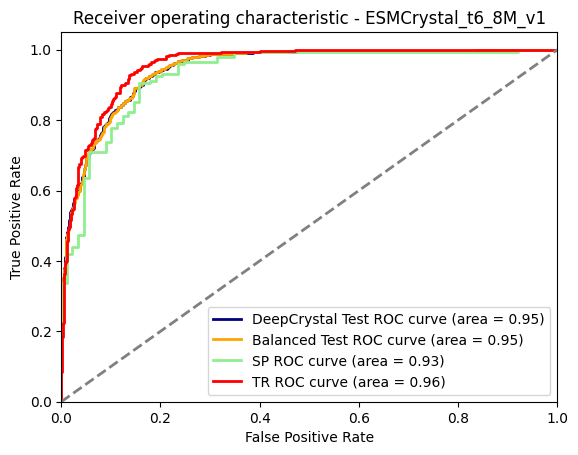

In [114]:
import matplotlib.pyplot as plt
plt.figure()
lw = 2

plt.plot(
    fpr_D[1],
    tpr_D[1],
    color="navy",
    lw=lw,
    label="DeepCrystal Test ROC curve (area = %0.2f)" % roc_auc_D[1],
)

plt.plot(
    fpr_B[1],
    tpr_B[1],
    color="orange",
    lw=lw,
    label="Balanced Test ROC curve (area = %0.2f)" % roc_auc_B[1],
)

plt.plot(
    fpr_S[1],
    tpr_S[1],
    color="lightgreen",
    lw=lw,
    label="SP ROC curve (area = %0.2f)" % roc_auc_S[1],
)

plt.plot(
    fpr_T[1],
    tpr_T[1],
    color="red",
    lw=lw,
    label="TR ROC curve (area = %0.2f)" % roc_auc_T[1],
)

plt.plot([0, 1], [0, 1], color="grey", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic - ESMCrystal_t6_8M_v1")
plt.legend(loc="lower right")
plt.show()

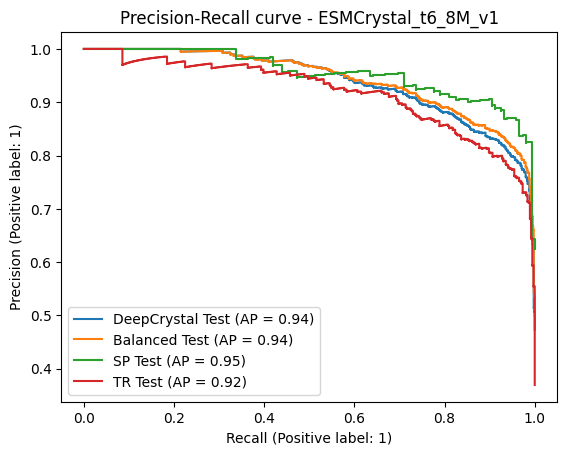

In [108]:
from sklearn.metrics import PrecisionRecallDisplay

import matplotlib.pyplot as plt
fig, ax = plt.subplots()

display = PrecisionRecallDisplay.from_predictions(y_test, predictions_D_proba, name="DeepCrystal Test", ax=ax)
display = PrecisionRecallDisplay.from_predictions(y_test_B, predictions_B_proba, name="Balanced Test", ax=ax)
display = PrecisionRecallDisplay.from_predictions(y_test_S, predictions_S_proba, name="SP Test", ax=ax)
display = PrecisionRecallDisplay.from_predictions(y_test_T, predictions_T_proba, name="TR Test", ax=ax)

_ = display.ax_.set_title("Precision-Recall curve - ESMCrystal_t6_8M_v1")
plt.show()